In [2]:
import climt
from gfs_dynamical_core import GFSDynamicalCore
from sympl import (
    PlotFunctionMonitor, NetCDFMonitor,
    TimeDifferencingWrapper, UpdateFrequencyWrapper,
)
from datetime import timedelta

import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import xarray as xr
import xesmf as xe

In [3]:
def plot_function(fig, state):

    ax = fig.add_subplot(2, 2, 1)
    state['specific_humidity'].mean(
        dim='lon').plot.contourf(
            ax=ax, levels=16, robust=True)
    ax.set_title('Specific Humidity')

    ax = fig.add_subplot(2, 2, 3)
    state['eastward_wind'].mean(dim='lon').plot.contourf(
        ax=ax, levels=16, robust=True)
    ax.set_title('Zonal Wind')

    ax = fig.add_subplot(2, 2, 2)
    state['air_temperature_tendency_from_convection'].transpose().mean(
        dim='lon').plot.contourf(
        ax=ax, levels=16, robust=True)
    ax.set_title('Conv. Heating Rate')

    ax = fig.add_subplot(2, 2, 4)
    state['air_temperature'].mean(dim='lon').plot.contourf(
        ax=ax, levels=16)
    ax.set_title('Temperature')

    fig.tight_layout()

In [4]:
def xr_open(dir, path): 
    return xr.open_mfdataset(dir+'/'+path+'/*.nc', combine='by_coords')

In [6]:
def regridding(xarr, tag, modifed_latitude, modifed_longitude):
    ds = xarr
    dr=ds[tag]

    ds_out = xr.Dataset(
        {
            "lat": (["lat"], modifed_latitude, {"units": "degrees_north"}),
            "lon": (["lon"], modifed_longitude, {"units": "degrees_east"}),
        }
    )

    regridder = xe.Regridder(ds, ds_out, "conservative")
    return regridder(dr, keep_attrs=True)

In [7]:
def plotter(dr, dr_out):
    """Create a single figure with two subplots"""
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(32, 16), subplot_kw={'projection': ccrs.PlateCarree()})

    # Plot the first data array
    p1 = dr.isel(time=0).plot.pcolormesh(ax=ax1, vmin=230, vmax=300, add_colorbar=False, transform=ccrs.PlateCarree())
    ax1.coastlines()
    ax1.set_title('WB1 Original 2m Temperature Plot (5.625 degree regular lattice)', fontsize=16)

    # Plot the second data array
    p2 = dr_out.isel(time=0).plot.pcolormesh(ax=ax2, vmin=230, vmax=300, add_colorbar=False, transform=ccrs.PlateCarree())
    ax2.coastlines()
    ax2.set_title('WB1 Regridded 2m Temperature Plot (~2.813 degree Gaussian lattice)',fontsize=16)

    # Add a single colorbar for both plots
    cbar = fig.colorbar(p2, ax=[ax1, ax2], orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label('Temperature [K]', fontsize=12)

    #plt.show()

In [14]:

# ----------------------------- SIMULATION PREPERATION -----------------------------

fields_to_store = ['air_temperature', 'air_pressure', 'eastward_wind',
                   'northward_wind', 'air_pressure_on_interface_levels',
                   'surface_pressure', 'upwelling_longwave_flux_in_air',
                   'specific_humidity', 'surface_temperature',
                   'latitude', 'longitude',
                   'convective_heating_rate']
                   
# Create plotting object
monitor = PlotFunctionMonitor(plot_function)
netcdf_monitor = NetCDFMonitor('gcm_without_seasonal_cycle.nc',
                               write_on_store=True,
                               store_names=fields_to_store)

climt.set_constants_from_dict({
    'stellar_irradiance': {'value': 200, 'units': 'W m^-2'}})

model_time_step = timedelta(seconds=600)
# Create components


convection = climt.EmanuelConvection()
simple_physics = TimeDifferencingWrapper(climt.SimplePhysics())

constant_duration = 6

radiation_lw = UpdateFrequencyWrapper(
    climt.RRTMGLongwave(), constant_duration*model_time_step)

radiation_sw = UpdateFrequencyWrapper(
    climt.RRTMGShortwave(), constant_duration*model_time_step)

slab_surface = climt.SlabSurface()

dycore = GFSDynamicalCore(
    [simple_physics, slab_surface, radiation_sw,
     radiation_lw, convection], number_of_damped_levels=5
)
grid = climt.get_grid(nx=128, ny=62)

# Create model state
my_state = climt.get_default_state([dycore], grid_state=grid)

# Set initial/boundary conditions
latitudes = my_state['latitude'].values
longitudes = my_state['longitude'].values

zenith_angle = np.radians(latitudes)
surface_shape = [len(longitudes), len(latitudes)]

my_state['zenith_angle'].values = zenith_angle
my_state['eastward_wind'].values[:] = np.random.randn(
    *my_state['eastward_wind'].shape)
my_state['ocean_mixed_layer_thickness'].values[:] = 50

surf_temp_profile = 290 - (40*np.sin(zenith_angle)**2)
my_state['surface_temperature'].values = surf_temp_profile


<Figure size 640x480 with 0 Axes>

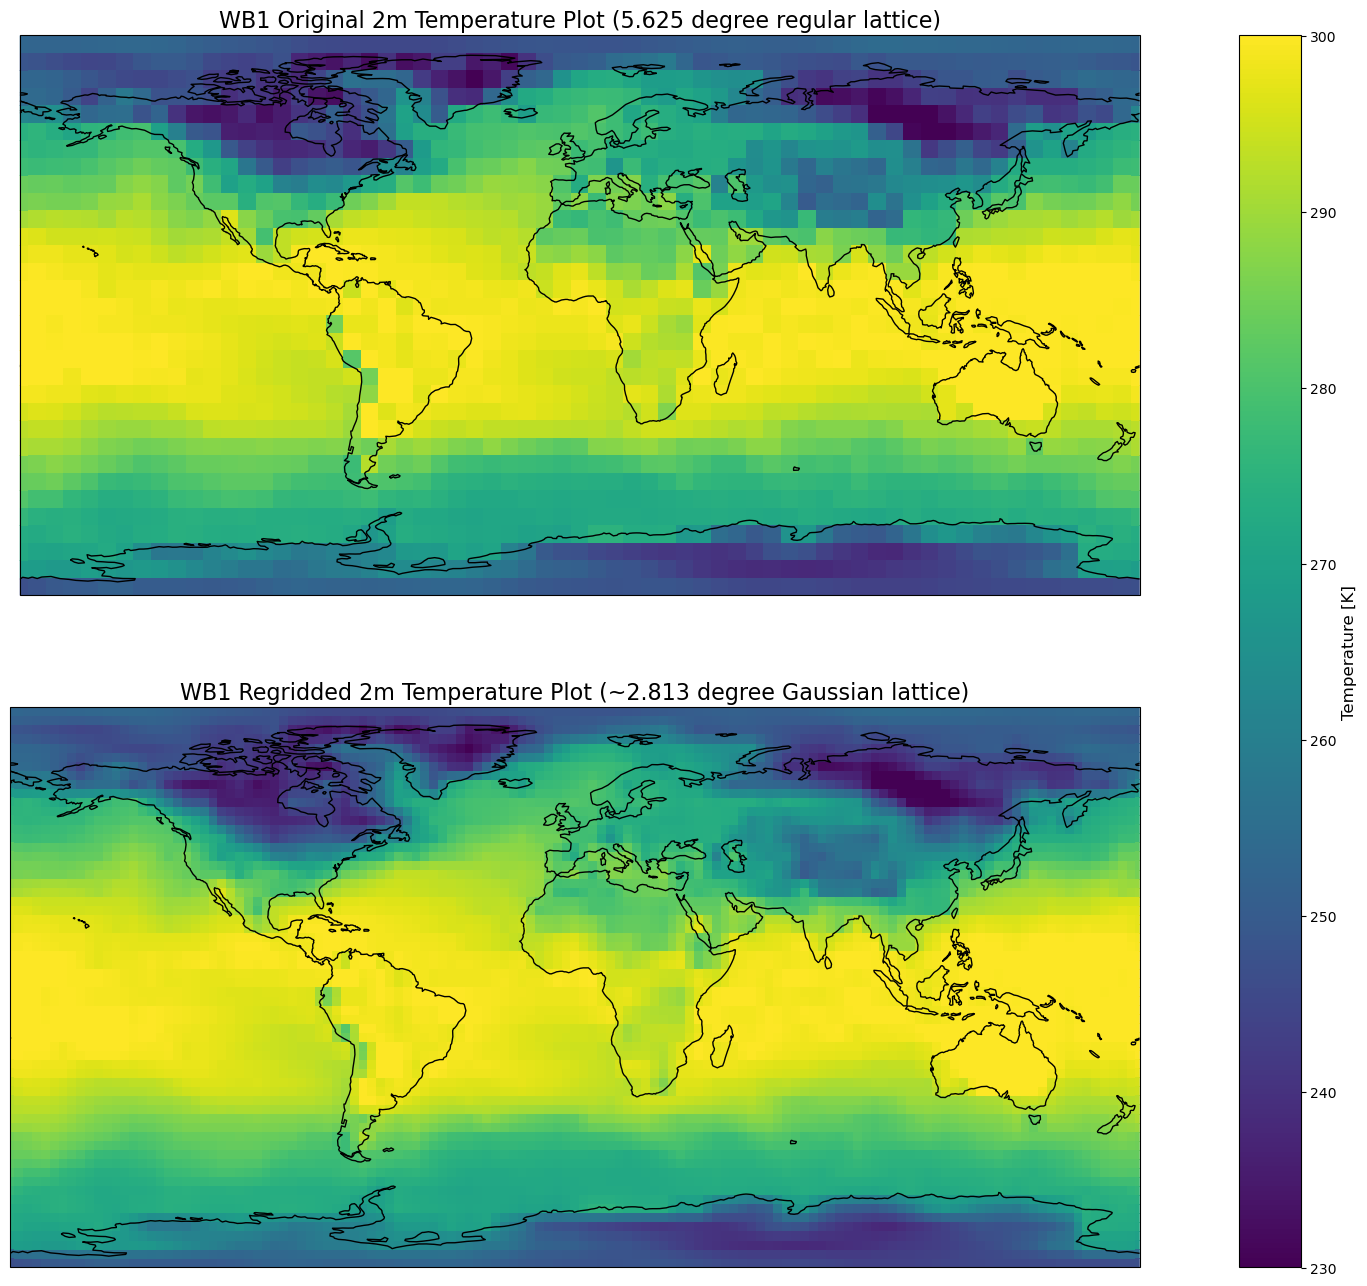

In [15]:

# ----------------------------- DATA PREPERATION -----------------------------

#Importing WB1 from local drive as xarrays + timesteps
wb1_dir='/run/media/adamh/HOME'
constants=xr_open(wb1_dir, 'constants')
_temperature=xr_open(wb1_dir, '2m_temperature')
temperature=xr_open(wb1_dir, 'temperature')
temperature_850=xr_open(wb1_dir, 'temperature_850')
_u_component_of_wind=xr_open(wb1_dir, '10m_u_component_of_wind')
_v_component_of_wind=xr_open(wb1_dir, '10m_v_component_of_wind')
u_component_of_wind=xr_open(wb1_dir, 'u_component_of_wind')
v_component_of_wind=xr_open(wb1_dir, 'v_component_of_wind')
geopotential=xr_open(wb1_dir, 'geopotential')
geopotential_500=xr_open(wb1_dir, 'geopotential_500')
relative_humidity=xr_open(wb1_dir, 'relative_humidity')
specific_humidity=xr_open(wb1_dir, 'specific_humidity')
potential_vorticity=xr_open(wb1_dir, 'potential_vorticity')
vorticity=xr_open(wb1_dir, 'vorticity')
toa_incident_solar_radiation=xr_open(wb1_dir, 'toa_incident_solar_radiation')
total_cloud_cover=xr_open(wb1_dir, 'total_cloud_cover')
total_precipitation=xr_open(wb1_dir, 'total_precipitation')
time_steps = temperature['time'].values

#adjusting climt lat and lon to match xesmf data structure
modifed_latitude = [coords[0] for coords in my_state['latitude'].values]
modifed_longitude = my_state['longitude'].values[0]

#regridding wb1 to match lattice in climt
_t_regridded = regridding(_temperature, "t2m",
                            modifed_latitude, modifed_longitude)
u_regridded = regridding(u_component_of_wind, "u",
                            modifed_latitude, modifed_longitude)
v_regridded = regridding(v_component_of_wind, "v",
                            modifed_latitude, modifed_longitude)
t_regridded = regridding(temperature, "t",
                            modifed_latitude, modifed_longitude)
q_regridded = regridding(specific_humidity, "q",
                            modifed_latitude, modifed_longitude)

#visualising regridding
plotter(_temperature["t2m"], _t_regridded)

In [16]:
# ----------------------------- SIMULATION -----------------------------

for i in range(30*24*6): #was 1500*24*6
    diag, my_state = dycore(my_state, model_time_step)
    my_state.update(diag)
    my_state['time'] += model_time_step

    if i % (6*24) == 0:
        netcdf_monitor.store(my_state)
        monitor.store(my_state)
        print('max. zonal wind: ',
              np.amax(my_state['eastward_wind'].values))
        print('max. humidity: ',
              np.amax(my_state['specific_humidity'].values))
        print('max. surf temp: ',
              my_state['surface_temperature'].max(keep_attrs=True).values)

    print(my_state['time'])

max. zonal wind:  2.2665874964349406
max. humidity:  0.00035413818120190834
max. surf temp:  289.9747407485055
2000-01-01 00:10:00
2000-01-01 00:20:00
2000-01-01 00:30:00
2000-01-01 00:40:00
2000-01-01 00:50:00
2000-01-01 01:00:00
2000-01-01 01:10:00
2000-01-01 01:20:00
2000-01-01 01:30:00
2000-01-01 01:40:00
2000-01-01 01:50:00
2000-01-01 02:00:00
2000-01-01 02:10:00
2000-01-01 02:20:00
2000-01-01 02:30:00
2000-01-01 02:40:00
2000-01-01 02:50:00
2000-01-01 03:00:00
2000-01-01 03:10:00
2000-01-01 03:20:00
2000-01-01 03:30:00
2000-01-01 03:40:00
2000-01-01 03:50:00
2000-01-01 04:00:00
2000-01-01 04:10:00
2000-01-01 04:20:00
2000-01-01 04:30:00
2000-01-01 04:40:00
2000-01-01 04:50:00
2000-01-01 05:00:00
2000-01-01 05:10:00
2000-01-01 05:20:00
2000-01-01 05:30:00
2000-01-01 05:40:00
2000-01-01 05:50:00
2000-01-01 06:00:00
2000-01-01 06:10:00
2000-01-01 06:20:00
2000-01-01 06:30:00
2000-01-01 06:40:00
2000-01-01 06:50:00
2000-01-01 07:00:00
2000-01-01 07:10:00
2000-01-01 07:20:00
2000-01-0